In [1]:
from time import strftime, gmtime, localtime

import pandas as pd
import numpy as np

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
#conda install -c conda-forge xgboost
import xgboost

import statsmodels.api as sm

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
#sns.set(rc={'patch.edgecolor': 'w', 'patch.force_edgecolor': True, 'patch.linewidth': 1})
%matplotlib inline

random_state = 42
np.random.seed(random_state)

print(strftime("Starting: %Y-%m-%d %H:%M:%S", localtime()))



Starting: 2018-11-18 10:25:11


In [2]:
#data = pd.read_pickle("data_clean.pickle")
data = pd.read_pickle("data.pickle")
data.sort_values(["DATETIME","GVKEY"],inplace=True)
data.reset_index(inplace=True)
data = data[["DATETIME","GVKEY","IND_CODE","VALUE","MOMENTUM","RET3"]]

data.head()

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET3
0,1963-01-31,1010,25,1.443624,0.126256,0.077724
1,1963-01-31,1040,6,0.448922,-0.477048,0.041148
2,1963-01-31,1043,41,0.255952,-0.390406,-0.056931
3,1963-01-31,1045,40,1.383475,-0.130926,0.082269
4,1963-01-31,1075,31,0.476919,-0.187948,-0.002032


In [3]:
X = data[["VALUE","MOMENTUM"]].values
#X = data[["VALUE", "MOMENTUM"]].values
X = np.hstack((X, pd.get_dummies(data["IND_CODE"], drop_first=True).values))
y = data["RET3"].values
X.shape, y.shape

((574590, 50), (574590,))

In [4]:
# create train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

Train R-squared: 0.003712


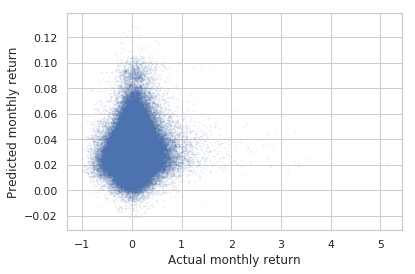

In [5]:
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Fitted vs. Actual
y_train_pred = model.predict(X_train)
print ("Train R-squared: %0.6f" % sklearn.metrics.r2_score(y_train, y_train_pred))

plt.scatter(y_train, y_train_pred, alpha=0.1, s=0.5);
plt.xlabel("Actual monthly return");
plt.ylabel("Predicted monthly return");

# your predictions are bad and you should feel bad


In [6]:
# split and scale for regularization 

xval_index = len(data.loc[data["DATETIME"] > pd.to_datetime("2013-01-01")])
test_index = len(data.loc[data["DATETIME"] > pd.to_datetime("2016-01-01")])

total_obs, predictors = X.shape
train_end = total_obs-xval_index
xval_end =  total_obs-test_index

train_indexes      = list(range(train_end))
train_xval_indexes = list(range(xval_end))
xval_indexes       = list(range(train_end,xval_end))
test_indexes       = list(range(xval_end, total_obs))

y=y.reshape(total_obs,1)
X_train = X[train_indexes]
y_train = y[train_indexes]

X_train_xval = X[train_xval_indexes]
y_train_xval = y[train_xval_indexes]

X_xval = X[xval_indexes]
y_xval = y[xval_indexes]

X_test = X[test_indexes]
y_test = y[test_indexes]

print(total_obs)
print(X_train.shape)
print(X_xval.shape)
print(X_test.shape)
print(X_train_xval.shape)

# scale
scaler = preprocessing.StandardScaler()
# train scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# transform only
X_train_xval_scaled = scaler.transform(X_train_xval)
X_xval_scaled = scaler.transform(X_xval)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# ys
scaler = preprocessing.StandardScaler()
y_train_scaled = scaler.fit_transform(y_train)
# transform only!
y_train_xval_scaled = scaler.transform(y_train_xval)
y_xval_scaled = scaler.transform(y_xval)
y_test_scaled = scaler.transform(y_test)



574590
(515327, 50)
(36658, 50)
(22605, 50)
(551985, 50)


In [7]:
# add a unit column because statsmodels needs it for an intercept
rows = X_train_scaled.shape[0]
z = np.ones((rows,1))
X_train_scaled_constant = np.hstack((z, X_train_scaled))
print(X_train_scaled_constant.shape)

rows = X_xval_scaled.shape[0]
z = np.ones((rows,1))
X_xval_scaled_constant = np.hstack((z, X_xval_scaled))
print(X_xval_scaled_constant.shape)


(515327, 51)
(36658, 51)


In [8]:
print(X_xval_scaled_constant.shape)
model = sm.OLS(y_train_scaled, X_train_scaled_constant)
results = model.fit()

y_train_predict = results.predict(X_train_scaled_constant).reshape(y_train_scaled.shape)
residuals = y_train_scaled - y_train_predict

print("Prediction mean: %.6f" % np.mean(y_train_predict))
print("Prediction SD:   %.6f" % np.mean(np.std(y_train_predict)))

results.summary()

(36658, 51)
Prediction mean: 0.000000
Prediction SD:   0.063596


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     41.85
Date:                Sun, 18 Nov 2018   Prob (F-statistic):               0.00
Time:                        10:25:18   Log-Likelihood:            -7.3017e+05
No. Observations:              515327   AIC:                         1.460e+06
Df Residuals:                  515276   BIC:                         1.461e+06
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.301e-17      0.001  -9.36e-15      1.000      -0.003       0.003
x1             0.0635      0.002     41.014      0.000       0.060       0.066
x2             0.0165      0.001     11.745      0.000       0.014       0.019
x3            -0.0059      0.002     -3.489      0.000      -0.009      -0.003
x4            -0.0059      0.004     -1.442      0.149      -0.014       0.002
x5            -0.0023      0.003     -0.863      0.388      -0.008       0.003
x6            -0.0062      0.002     -2.530      0.011      -0.011      -0.001
x7             0.0034      0.002      1.729      0.084      -0.000       0.007
x8            -0.0075      0.002     -3.322      0.001      -0.012      -0.003
x9            -0.0005      0.003     -0.214      0.831      -0.006       0.004
x10           -0.0048      0.003     -1.546      0.122      -0.011       0.001
x11           -0.0109      0.004     -2.735      0.006      -0.019      -0.003
x12           -0.0077      0.003     -2.929      0.003      -0.013      -0.003
x13           -0.0059      0.003     -1.977      0.048      -0.012    -5.2e-05
x14           -0.0039      0.004     -1.115      0.265      -0.011       0.003
x15           -0.0009      0.005     -0.181      0.856      -0.010       0.008
x16           -0.0130      0.005     -2.713      0.007      -0.022      -0.004
x17           -0.0035      0.002     -1.557      0.120      -0.008       0.001
x18           -0.0122      0.002     -5.801      0.000      -0.016      -0.008
x19           -0.0132      0.004     -3.377      0.001      -0.021      -0.006
x20           -0.0120      0.002     -4.826      0.000      -0.017      -0.007
x21           -0.0222      0.004     -5.805      0.000      -0.030      -0.015
x22           -0.0045      0.002     -2.319      0.020      -0.008      -0.001
x23           -0.0150      0.005     -3.071      0.002      -0.025      -0.005
x24           -0.0081      0.003     -3.076      0.002      -0.013      -0.003
x25           -0.0211      0.004     -5.198      0.000      -0.029      -0.013
x26           -0.0027      0.002     -1.118      0.264      -0.008       0.002
x27           -0.0028      0.002     -1.701      0.089      -0.006       0.000
x28           -0.0060      0.002     -2.487      0.013      -0.011      -0.001
x29           -0.0090      0.003     -3.465      0.001      -0.014      -0.004
x30           -0.0059      0.003     -1.847      0.065      -0.012       0.000
x31           -0.0015      0.002     -0.798      0.425      -0.005       0.002
x32           -0.0147      0.006     -2.317      0.020      -0.027      -0.002
x33           -0.0404      0.008     -5.266      0.000      -0.055      -0.025
x34           -0.0147      0.005     -2.938      0.003      -0.024      -0.005
x35           -0.0105      0.002     -4.523      0.000      -0.015      -0.006
x3

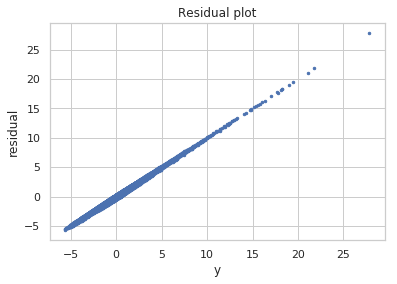

In [9]:
# plot residuals
plt.scatter(y_train_scaled, residuals, s=6);
plt.title('Residual plot');
plt.xlabel('y');
plt.ylabel('residual');
# predictions are near 0
# ys have a broad spread
# it's almost like plotting y vs. y

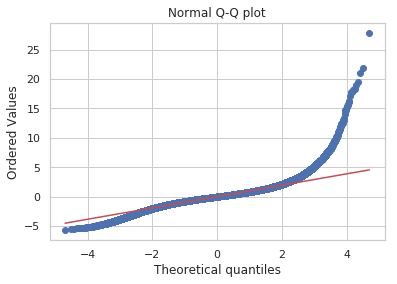

In [10]:
# q-q plot
stats.probplot(residuals[:,0], dist="norm", plot=plt)
plt.title("Normal Q-Q plot");



Train R-squared: 0.004044
Xval R-squared: -0.001899


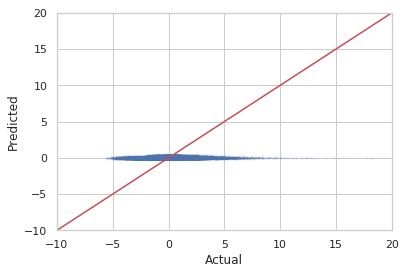

In [11]:
# Fitted vs. Actual
y_train_pred = results.predict(X_train_scaled_constant)
print ("Train R-squared: %0.6f" % sklearn.metrics.r2_score(y_train_scaled, y_train_pred))

# xval R-squared 
y_xval_pred = results.predict(X_xval_scaled_constant)
print ("Xval R-squared: %0.6f" % sklearn.metrics.r2_score(y_xval_scaled, y_xval_pred))

plt.scatter(y_train_scaled, y_train_pred, alpha=0.1, s=0.5);
#plt.ylim(-0.05, 0.15) 
plt.ylim(-10, 20) 
plt.xlim(-10, 20) 
fortyfiveline = np.array([-10, 20])

plt.plot(fortyfiveline, fortyfiveline, c='r')
plt.xlabel("Actual");
plt.ylabel("Predicted");

Train R-squared: 0.004044
Xval R-squared: -0.001899


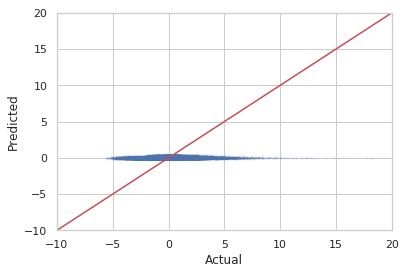

In [12]:
# do same with sklearn instead of statsmodels
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

# Fitted vs. Actual
y_train_pred = model.predict(X_train_scaled)
print ("Train R-squared: %0.6f" % sklearn.metrics.r2_score(y_train_scaled, y_train_pred))

# xval R-squared 
y_xval_pred = model.predict(X_xval_scaled)
print ("Xval R-squared: %0.6f" % sklearn.metrics.r2_score(y_xval_scaled, y_xval_pred))

plt.scatter(y_train_scaled, y_train_pred, alpha=0.1, s=0.5);
#plt.ylim(-0.05, 0.15) 
plt.ylim(-10, 20) 
plt.xlim(-10, 20) 
fortyfiveline = np.array([-10, 20])

plt.plot(fortyfiveline, fortyfiveline, c='r')
plt.xlabel("Actual");
plt.ylabel("Predicted");

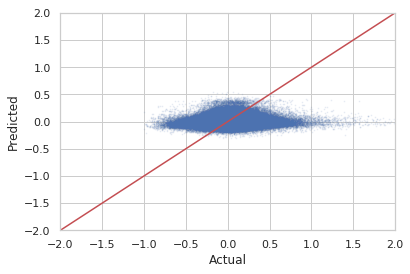

In [13]:

plt.ylim(-2, 2) 
plt.xlim(-2, 2) 
fortyfiveline = np.array([-2, 2])

plt.plot(fortyfiveline, fortyfiveline, c='r')
plt.scatter(y_train, y_train_pred, alpha=0.1, s=0.5);
plt.xlabel("Actual");
plt.ylabel("Predicted");

In [14]:
# grid search harness
def build_grid_search_est(model, X, y, params, cv):
    
    #n_jobs = 4 because 8 or -1 maxes out memory and dies
    grid_est = GridSearchCV(model, param_grid=params, cv=cv, scoring="r2", n_jobs=4)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        tempdf = df.groupby(['param_' + param]).mean().reset_index()
        plt.semilogx(tempdf['param_' + param], tempdf.mean_test_score)
        plt.show()
    return grid_est

Lasso Model:
alphas to test
[1.00000000e-06 3.16227766e-06 1.00000000e-05 3.16227766e-05
 1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

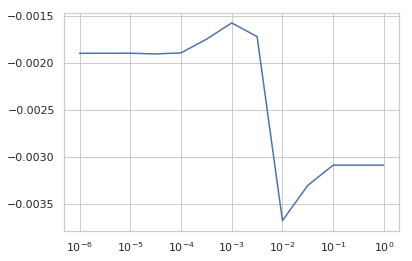

{'alpha': 0.001}
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
6,1.347672,0.0,0.003398,0.0,0.001,{'alpha': 0.001},-0.001576,-0.001576,0.000000e+00,1,0.003982,0.003982,0.0
7,0.985339,0.0,0.003479,0.0,0.00316228,{'alpha': 0.0031622776601683794},-0.001720,-0.001720,0.000000e+00,2,0.003673,0.003673,0.0
5,2.368483,0.0,0.003533,0.0,0.000316228,{'alpha': 0.00031622776601683794},-0.001749,-0.001749,0.000000e+00,3,0.004023,0.004023,0.0
4,10.025079,0.0,0.003453,0.0,0.0001,{'alpha': 0.0001},-0.001893,-0.001893,0.000000e+00,4,0.004033,0.004033,0.0
2,80.248212,0.0,0.003425,0.0,1e-05,{'alpha': 1e-05},-0.001897,-0.001897,0.000000e+00,5,0.004043,0.004043,0.0
1,86.559103,0.0,0.003293,0.0,3.16228e-06,{'alpha': 3.162277660168379e-06},-0.001897,-0.001897,0.000000e+00,6,0.004044,0.004044,0.0
0,99.268604,0.0,0.003031,0.0,1e-06,{'alpha': 1e-06},-0.001898,-0.001898,0.000000e+00,7,0.004044,0.004044,0.0
3,41.537958,0.0,0.003806,0.0,3.16228e-05,{'alpha': 3.1622776601683795e-05},-0.001904,-0.001904,2.168404e-19,8,0.004040,0.004040,0.0
10,0.723680,0.0,0.003483,0.0,0.1,{'alpha': 0.1},-0.003084,-0.003084,0.000000e+00,9,0.000000,0.000000,0.0
11,0.722275,0.0,0.003518,0.0,0.316228,{'alpha': 0.31622776601683794},-0.003084,-0.003084,0.000000e+00,9,0.000000,0.000000,0.0


In [15]:
# grid search on Lasso to find best alpha

print("Lasso Model:")
params = {
    "alpha": np.logspace(-6, 0, 13)
}

print("alphas to test")
print(params['alpha'])

grid_est = build_grid_search_est(Lasso(), 
                                 X_train_xval_scaled, y_train_xval_scaled, 
                                 params, 
                                 cv=[(train_indexes, xval_indexes)])

print(grid_est.best_params_)
print(grid_est.best_estimator_)
best_lasso_alpha = grid_est.best_params_['alpha']

pd.DataFrame(grid_est.cv_results_).sort_values("mean_test_score", ascending=False)


Train R-squared: 0.003269


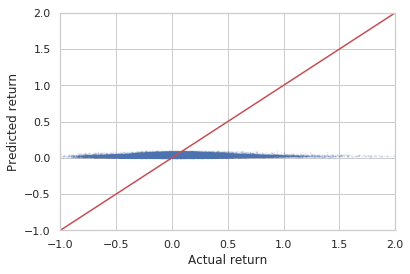

Xval R-squared: -0.002502
End: 2018-11-18 10:27:18


In [16]:
# rerun best estimator on full dataset

def run_one_model(model, X_train_scaled, y_train):

    # Build the model
    
    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_train_pred = model.predict(X_train_scaled)
    print ("Train R-squared: %0.6f" % sklearn.metrics.r2_score(y_train, y_train_pred))

    plt.ylim(-1, 2) 
    plt.xlim(-1, 2) 
    fortyfiveline = np.array([-1, 2])

    plt.plot(fortyfiveline, fortyfiveline, c='r')
    plt.scatter(y_train, y_train_pred, alpha=0.1, s=0.5);
    plt.xlabel("Actual return");
    plt.ylabel("Predicted return");
    plt.show();
    
    return model

model=run_one_model(Lasso(alpha=best_lasso_alpha, random_state=random_state),
                    X_train_scaled, y_train)
y_xval_pred = model.predict(X_xval_scaled)
print ("Xval R-squared: %0.6f" % sklearn.metrics.r2_score(y_xval, y_xval_pred))
print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))    

# this is not working, because xval R-squared is still negative
# may increase lasso penalty until you are essentially predicting a constant

Ridge Model:
alphas to test
[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03 3.16227766e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05 1.00000000e+06 3.16227766e+06
 1.00000000e+07 3.16227766e+07 1.00000000e+08]


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

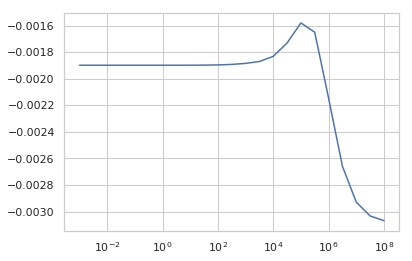

{'alpha': 100000.0}
Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
16,0.357221,0.0,0.003077,0.0,100000,{'alpha': 100000.0},-0.001580,-0.001580,0.000000e+00,1,0.003834,0.003834,0.0
17,0.372624,0.0,0.003050,0.0,316228,{'alpha': 316227.7660168379},-0.001651,-0.001651,0.000000e+00,2,0.003165,0.003165,0.0
15,0.364207,0.0,0.003192,0.0,31622.8,{'alpha': 31622.776601683792},-0.001731,-0.001731,0.000000e+00,3,0.004001,0.004001,0.0
14,0.361243,0.0,0.003097,0.0,10000,{'alpha': 10000.0},-0.001832,-0.001832,2.168404e-19,4,0.004028,0.004028,0.0
13,0.357326,0.0,0.003149,0.0,3162.28,{'alpha': 3162.2776601683795},-0.001871,-0.001871,2.168404e-19,5,0.004036,0.004036,0.0
12,0.450081,0.0,0.003006,0.0,1000,{'alpha': 1000.0},-0.001885,-0.001885,0.000000e+00,6,0.004042,0.004042,0.0
11,0.467393,0.0,0.003182,0.0,316.228,{'alpha': 316.22776601683796},-0.001892,-0.001892,0.000000e+00,7,0.004044,0.004044,0.0
10,0.353159,0.0,0.002987,0.0,100,{'alpha': 100.0},-0.001896,-0.001896,0.000000e+00,8,0.004044,0.004044,0.0
9,0.358457,0.0,0.003134,0.0,31.6228,{'alpha': 31.622776601683793},-0.001898,-0.001898,2.168404e-19,9,0.004044,0.004044,0.0
8,0.354294,0.0,0.002961,0.0,10,{'alpha': 10.0},-0.001898,-0.001898,0.000000e+00,10,0.004044,0.004044,0.0


In [17]:
print("Ridge Model:")

params = {
    "alpha": np.logspace(-3, 8, (8+3)*2+1)
}

print("alphas to test")
print(params['alpha'])

grid_est = build_grid_search_est(Ridge(), 
                                 X_train_xval_scaled, y_train_xval, 
                                 params, 
                                 cv=[(train_indexes, xval_indexes)])

print(grid_est.best_params_)
print(grid_est.best_estimator_)
best_ridge_alpha = grid_est.best_params_['alpha']

pd.DataFrame(grid_est.cv_results_).sort_values("mean_test_score", ascending=False)


In [18]:
best_ridge_alpha 

100000.0

Train R-squared: 0.003834


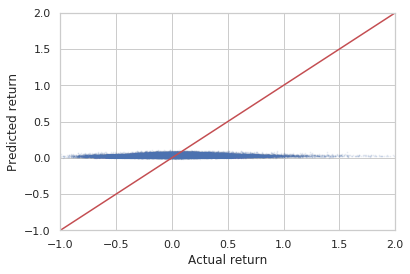

Xval R-squared: -0.001580
End: 2018-11-18 10:27:25


In [19]:
# do the best one on full train

model = run_one_model(Ridge(alpha=best_ridge_alpha, random_state=random_state),
              X_train_scaled, y_train)

y_xval_pred = model.predict(X_xval_scaled)
print ("Xval R-squared: %0.6f" % sklearn.metrics.r2_score(y_xval, y_xval_pred))
print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))    



Elastic Net Grid Search
{'alpha': array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05]), 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

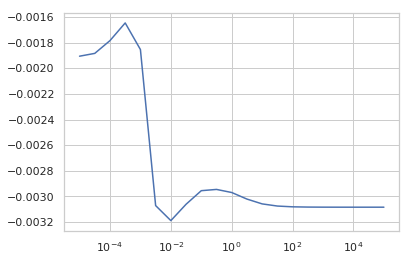

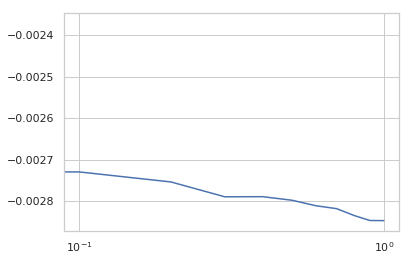

{'alpha': 0.0031622776601683794, 'l1_ratio': 0.1}
ElasticNet(alpha=0.0031622776601683794, copy_X=True, fit_intercept=True,
      l1_ratio=0.1, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
56,1.135633,0.0,0.003543,0.0,0.00316228,0.1,"{'alpha': 0.0031622776601683794, 'l1_ratio': 0.1}",-0.001522,-0.001522,0.000000e+00,1,0.003900,0.003900,0.0
43,1.048923,0.0,0.003346,0.0,0.000316228,1,"{'alpha': 0.00031622776601683794, 'l1_ratio': ...",-0.001527,-0.001527,0.000000e+00,2,0.003903,0.003903,0.0
48,1.101820,0.0,0.003447,0.0,0.001,0.4,"{'alpha': 0.001, 'l1_ratio': 0.4}",-0.001531,-0.001531,0.000000e+00,3,0.003839,0.003839,0.0
47,1.119104,0.0,0.003511,0.0,0.001,0.3,"{'alpha': 0.001, 'l1_ratio': 0.30000000000000004}",-0.001533,-0.001533,0.000000e+00,4,0.003913,0.003913,0.0
42,1.077271,0.0,0.003476,0.0,0.000316228,0.9,"{'alpha': 0.00031622776601683794, 'l1_ratio': ...",-0.001541,-0.001541,0.000000e+00,5,0.003924,0.003924,0.0
41,1.143778,0.0,0.003354,0.0,0.000316228,0.8,"{'alpha': 0.00031622776601683794, 'l1_ratio': ...",-0.001548,-0.001548,0.000000e+00,6,0.003944,0.003944,0.0
40,1.167280,0.0,0.003471,0.0,0.000316228,0.7,"{'alpha': 0.00031622776601683794, 'l1_ratio': ...",-0.001554,-0.001554,0.000000e+00,7,0.003963,0.003963,0.0
99,117.446238,0.0,0.003522,0.0,0.316228,0,"{'alpha': 0.31622776601683794, 'l1_ratio': 0.0}",-0.001558,-0.001558,0.000000e+00,8,0.003636,0.003636,0.0
46,1.310970,0.0,0.003542,0.0,0.001,0.2,"{'alpha': 0.001, 'l1_ratio': 0.2}",-0.001560,-0.001560,0.000000e+00,9,0.003973,0.003973,0.0
39,1.318157,0.0,0.003378,0.0,0.000316228,0.6,"{'alpha': 0.00031622776601683794, 'l1_ratio': ...",-0.001570,-0.001570,0.000000e+00,10,0.003979,0.003979,0.0


In [20]:
# ElasticNet: combine l1 (lasso) and l2 (ridge) penalties

print("Elastic Net Grid Search")
params = {
    "alpha": np.logspace(-5, 5, 21),
    "l1_ratio": np.linspace(0.0, 1.0, 11)
}

print(params)

grid_est = build_grid_search_est(ElasticNet(), 
                                 X_train_xval_scaled, 
                                 y_train_xval, 
                                 params, cv=[(train_indexes, xval_indexes)])


print(grid_est.best_params_)
print(grid_est.best_estimator_)

best_elasticnet_alpha = grid_est.best_params_['alpha']
best_elasticnet_ratio = grid_est.best_params_['l1_ratio']

pd.DataFrame(grid_est.cv_results_).sort_values("mean_test_score", ascending=False)


Train R-squared: 0.003900


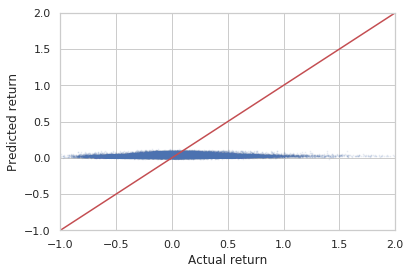

Xval R-squared: -0.001522
2018-11-18 10:41:08


In [21]:

model = run_one_model(ElasticNet(alpha=best_elasticnet_alpha, 
                                 l1_ratio=best_elasticnet_ratio, 
                                 random_state=random_state),
                      X_train_scaled, y_train)

y_xval_pred = model.predict(X_xval_scaled)
print ("Xval R-squared: %0.6f" % sklearn.metrics.r2_score(y_xval, y_xval_pred))
print(strftime("%Y-%m-%d %H:%M:%S", localtime()))    



In [22]:
# enumerate regressors (estimators which are not classifiers)
from sklearn.base import ClassifierMixin
from sklearn.utils.testing import all_estimators
#classifiers=[est for est in all_estimators() if not issubclass(est[1], ClassifierMixin)]

estimators = []
for name, class_ in all_estimators():
    if not issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict'):
            print(class_)
            estimators.append(class_)

<class 'sklearn.linear_model.bayes.ARDRegression'>
<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>
<class 'sklearn.cluster.affinity_propagation_.AffinityPropagation'>
<class 'sklearn.ensemble.bagging.BaggingRegressor'>
<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>
<class 'sklearn.linear_model.bayes.BayesianRidge'>
<class 'sklearn.cluster.birch.Birch'>
<class 'sklearn.cross_decomposition.cca_.CCA'>
<class 'sklearn.tree.tree.DecisionTreeRegressor'>
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'>
<class 'sklearn.linear_model.coordinate_descent.ElasticNetCV'>
<class 'sklearn.covariance.elliptic_envelope.EllipticEnvelope'>
<class 'sklearn.tree.tree.ExtraTreeRegressor'>
<class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
<class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
<class 'sklearn.gaussian_process.gpr.GaussianProcessRegressor'>
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
<class 'sklearn.linear_model.hub

In [23]:
# tune Random Forest
# from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = sklearn.ensemble.forest.RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 64, cv = kfold, verbose=2, random_state=42, n_jobs = 4)
# # Fit the random search model
# rf_random.fit(X_train_scaled, y_train)
# rf_random.best_params_


In [24]:
# ones commented out twice didn't work at all, or took very long
# others were OK but not good enough to keep 

estimators = [
     sklearn.linear_model.base.LinearRegression(),
     xgboost.XGBRegressor(n_estimators=400,
                          max_depth=8,
                          n_jobs=4),
     sklearn.ensemble.forest.RandomForestRegressor(n_jobs=4),
#     sklearn.ensemble.forest.ExtraTreesRegressor(),
     sklearn.linear_model.coordinate_descent.Lasso(alpha=best_lasso_alpha, random_state=random_state),
     sklearn.linear_model.ridge.Ridge(alpha=best_ridge_alpha, random_state=random_state),
     sklearn.linear_model.coordinate_descent.ElasticNet(alpha=best_elasticnet_alpha, 
                                                        l1_ratio=best_elasticnet_ratio, 
                                                        random_state=random_state),
#     sklearn.ensemble.bagging.BaggingRegressor(),
#     sklearn.ensemble.gradient_boosting.GradientBoostingRegressor(),
#     #sklearn.ensemble.weight_boosting.AdaBoostRegressor(),
#     sklearn.kernel_ridge.KernelRidge(),
#     sklearn.linear_model.bayes.BayesianRidge(),
#     sklearn.linear_model.huber.HuberRegressor,
#     sklearn.linear_model.least_angle.Lars(),
#     sklearn.linear_model.least_angle.LassoLars(),
#     sklearn.linear_model.least_angle.LassoLarsIC(),
#     sklearn.linear_model.omp.OrthogonalMatchingPursuit(),
#     sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor(),
# #     sklearn.linear_model.ransac.RANSACRegressor,
#     sklearn.linear_model.stochastic_gradient.SGDRegressor(),
# #    sklearn.neighbors.regression.KNeighborsRegressor(),
    sklearn.neural_network.multilayer_perceptron.MLPRegressor(hidden_layer_sizes=(32,8)), 
#     sklearn.svm.classes.LinearSVR(),
# #    sklearn.svm.classes.NuSVR(),
# #    sklearn.svm.classes.SVR(),
]

Start: 2018-11-18 10:41:09
LR
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Train R-squared: 0.004044


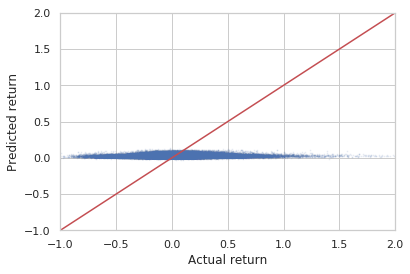

Xval R-squared: -0.001899
End: 2018-11-18 10:41:12
------------------------------------------------------------
Start: 2018-11-18 10:41:12
XGB
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Train R-squared: 0.124369


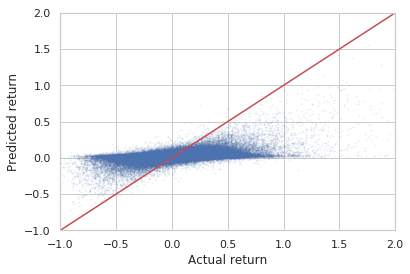

Xval R-squared: -0.027731
End: 2018-11-18 10:42:56
------------------------------------------------------------
Start: 2018-11-18 10:42:58
RF
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Train R-squared: 0.818303


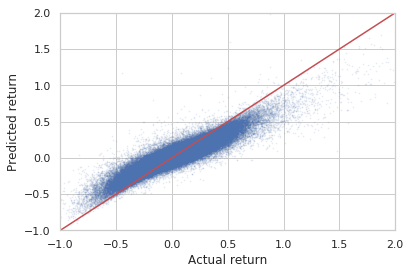

Xval R-squared: -0.356597
End: 2018-11-18 10:43:24
------------------------------------------------------------
Start: 2018-11-18 10:43:25
LASSO
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)
Train R-squared: 0.003269


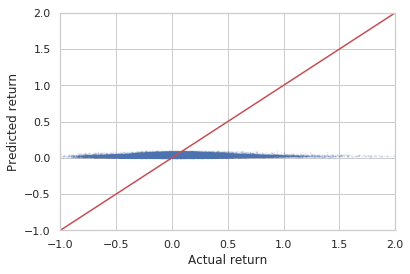

Xval R-squared: -0.002502
End: 2018-11-18 10:43:28
------------------------------------------------------------
Start: 2018-11-18 10:43:28
RIDGE
Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)
Train R-squared: 0.003834


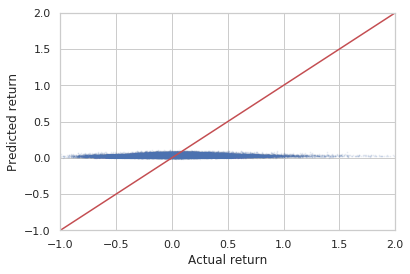

Xval R-squared: -0.001580
End: 2018-11-18 10:43:31
------------------------------------------------------------
Start: 2018-11-18 10:43:31
EL
ElasticNet(alpha=0.0031622776601683794, copy_X=True, fit_intercept=True,
      l1_ratio=0.1, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=42, selection='cyclic', tol=0.0001,
      warm_start=False)
Train R-squared: 0.003900


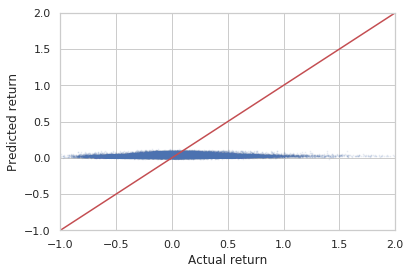

Xval R-squared: -0.001522
End: 2018-11-18 10:43:35
------------------------------------------------------------
Start: 2018-11-18 10:43:35
MLP
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(32, 8), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train R-squared: 0.005733


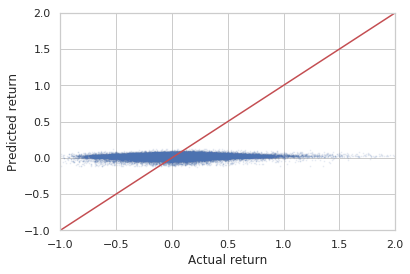

Xval R-squared: -0.006422
End: 2018-11-18 10:43:51
------------------------------------------------------------


In [25]:
# train on training set
# predict on entire dataset and save predictions

estimator_names = ["LR", "XGB", "RF", "LASSO", "RIDGE", "EL", "MLP"]

for estname, est in zip(estimator_names, estimators):
    print(strftime("Start: %Y-%m-%d %H:%M:%S", localtime()))    
    print(estname)
    print(est)
    model = run_one_model(est, X_train_scaled, y_train)
    
    y_xval_pred = model.predict(X_xval_scaled)
    print ("Xval R-squared: %0.6f" % sklearn.metrics.r2_score(y_xval, y_xval_pred))
    print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))    
    print("------------------------------------------------------------")
    
    #predict on full X
    data[estname] = model.predict(X_scaled)

# save predictions to backtest performance
data.to_pickle("data_forecast.pickle")



Start: 2018-11-18 10:43:52
RF
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Train R-squared: 0.819385


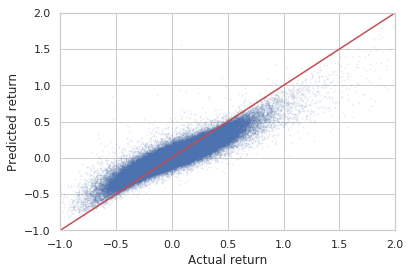

Xval R-squared: -0.373538
End: 2018-11-18 10:45:03
------------------------------------------------------------


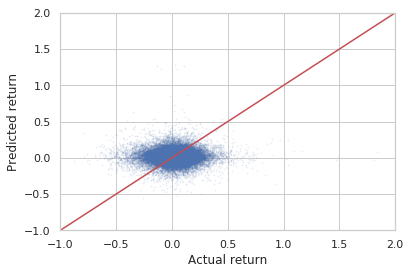

Test R-squared: -0.493788
End: 2018-11-18 10:45:04
------------------------------------------------------------


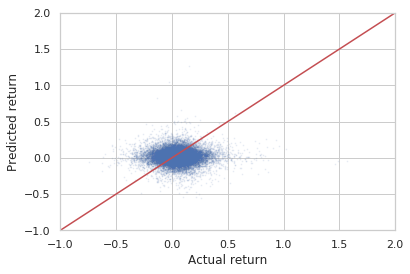

In [26]:
    # run these in test
    estname = "RF"
    est = sklearn.ensemble.forest.RandomForestRegressor()
    print(strftime("Start: %Y-%m-%d %H:%M:%S", localtime()))    
    print(estname)
    print(est)
    rf_model = run_one_model(est, X_train_scaled, y_train)
    y_xval_pred = rf_model.predict(X_xval_scaled)

    print ("Xval R-squared: %0.6f" % sklearn.metrics.r2_score(y_xval, y_xval_pred))
    print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))    
    print("------------------------------------------------------------")
    
    #predict on xval
    plt.scatter(y_xval, y_xval_pred, alpha=0.1, s=0.5);
    #plt.ylim(-0.05, 0.15) 
    plt.ylim(-1, 2) 
    plt.xlim(-1, 2) 
    fortyfiveline = np.array([-1, 2])
    plt.plot(fortyfiveline, fortyfiveline, c='r')
    plt.xlabel("Actual return");
    plt.ylabel("Predicted return");
    plt.show()
    
    # test
    y_test_pred = rf_model.predict(X_test_scaled)
    print ("Test R-squared: %0.6f" % sklearn.metrics.r2_score(y_test, y_test_pred))
    print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))    
    print("------------------------------------------------------------")

    plt.scatter(y_test, y_test_pred, alpha=0.1, s=0.5);
    #plt.ylim(-0.05, 0.15) 
    plt.ylim(-1, 2) 
    plt.xlim(-1, 2) 
    fortyfiveline = np.array([-1, 2])
    plt.plot(fortyfiveline, fortyfiveline, c='r')
    plt.xlabel("Actual return");
    plt.ylabel("Predicted return");

Start: 2018-11-18 10:45:04
XGB
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Train R-squared: 0.124369


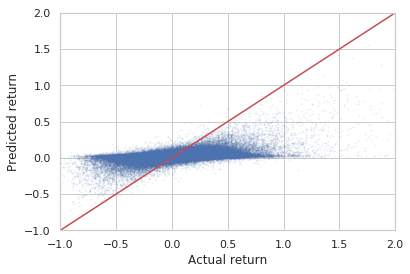

Xval R-squared: -0.027731
End: 2018-11-18 10:51:32
------------------------------------------------------------


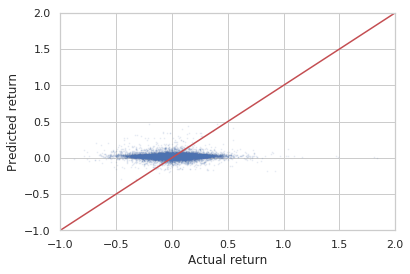

Test R-squared: -0.071882
End: 2018-11-18 10:51:32
------------------------------------------------------------


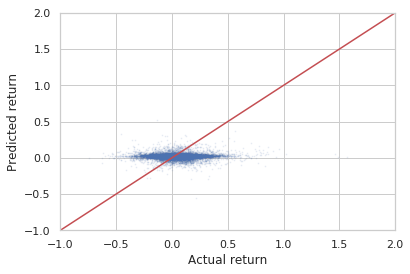

In [27]:
    estname = "XGB"
    est = xgboost.XGBRegressor(n_estimators=400,
                               max_depth=8)
    print(strftime("Start: %Y-%m-%d %H:%M:%S", localtime()))    
    print(estname)
    print(est)
    xgb_model = run_one_model(est, X_train_scaled, y_train)
    
    y_xval_pred = xgb_model.predict(X_xval_scaled)
    
    print ("Xval R-squared: %0.6f" % sklearn.metrics.r2_score(y_xval, y_xval_pred))
    print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))    
    print("------------------------------------------------------------")

    plt.scatter(y_xval, y_xval_pred, alpha=0.1, s=0.5);
    #plt.ylim(-0.05, 0.15) 
    plt.ylim(-1, 2) 
    plt.xlim(-1, 2) 
    fortyfiveline = np.array([-1, 2])

    plt.plot(fortyfiveline, fortyfiveline, c='r')
    plt.xlabel("Actual return");
    plt.ylabel("Predicted return");
    
    plt.show()

    y_test_pred = xgb_model.predict(X_test_scaled)
    
    print ("Test R-squared: %0.6f" % sklearn.metrics.r2_score(y_test, y_test_pred))
    print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))    
    print("------------------------------------------------------------")

    plt.scatter(y_test, y_test_pred, alpha=0.1, s=0.5);
    #plt.ylim(-0.05, 0.15) 
    plt.ylim(-1, 2) 
    plt.xlim(-1, 2) 
    fortyfiveline = np.array([-1, 2])

    plt.plot(fortyfiveline, fortyfiveline, c='r')
    plt.xlabel("Actual return");
    plt.ylabel("Predicted return");

In [28]:
print(strftime("End: %Y-%m-%d %H:%M:%S", localtime()))


End: 2018-11-18 10:51:33
